*Apple is now the most valuable US public company* By Krystal Hur, CNN Thu June 13, 2024 <br>
https://edition.cnn.com/2024/06/13/investing/apple-microsoft-market-cap-nvidia/index.html <br>

*Nasdaq, S&P 500 post record closing highs as Apple soars* By Caroline Valetkevitch, June 12, 2024 <br>
https://www.reuters.com/markets/us/futures-fall-markets-await-fed-decision-cpi-data-2024-06-11/ <br>

*Famous Analyst Thinks Apple Inc (NASDAQ:AAPL) is a Better AI Investment Than Nvidia(NVDA) — Here’s Why* By Fahad Saleem, Jun 8, 2024 <br>
https://finance.yahoo.com/news/famous-analyst-thinks-apple-inc-192335822.html <br>

Today is Saturday, June 15th, 2024. After reading the above articles, I am wondering:<br> 
**Should I invest in AAPL? What is the chance of returns of 12% in a year?** <br>
**Is there a potential loss? How much is that?** <br>

This project is for me to learn to answer those questions. I briefly learned Monte Carlo Simulation in my junior Numerical Analisys class.<br>
So, I will use **Monte Carlo Simulation** to: <br>
* Simulate AAPL future prices (portfolio values).
* Risk Analysis (VaR & CVaR Calculation).

In [87]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [88]:
#import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [89]:
#stock data from Yahoo Finance
import yfinance as yf
stock = 'AAPL'
period = '252d' # approximate number of US trading days
data = yf.download(stock, period=period)
#daily return
returns = data['Adj Close'].pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed


In [90]:
#general parameters
#confidence levels
confidence_levels = [0.90, 0.95, 0.99]
#initial investment
initial_investment = 100000  # $100,000
# simulation parameters
num_simulations = 10000
simulation_horizon = 252  # Number of trading days in a year or forecast days

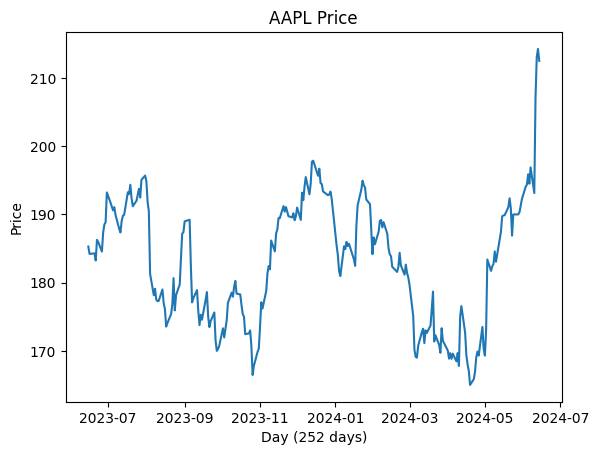

In [91]:
#Let's plot this stock prices
plt.plot(data['Adj Close'])
plt.title(f'{stock} Price')
plt.xlabel("Day (252 days)")
plt.ylabel("Price")
plt.show()

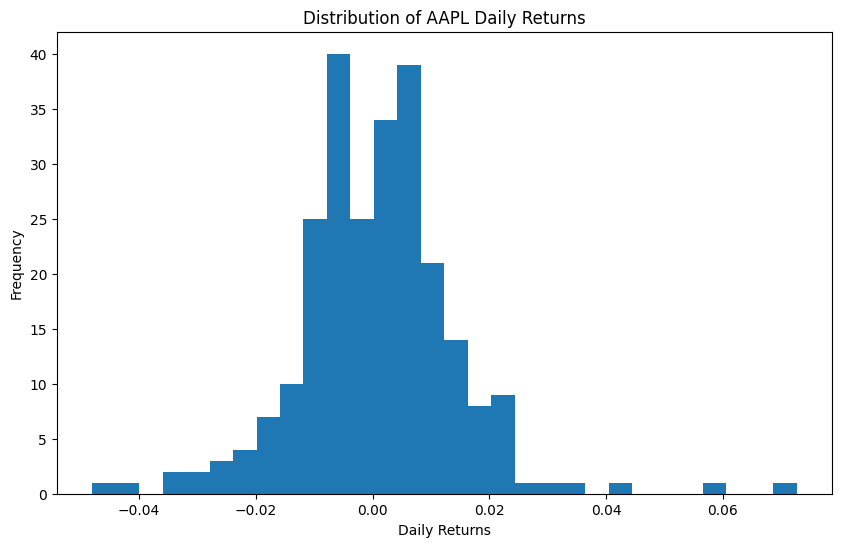

In [92]:
#Distribution of Daily Returns
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30)
plt.title(f'Distribution of {stock} Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

**Monte Carlo Simulation**<br>

In [93]:
#Calculate the average daily return
mean_value = returns.mean()

#Calculate volatility as the standard deviation of daily returns
std_dev = returns.std()

#By using mean & volatility of past 252 days to generate simulate daily returns
returns_sim = np.random.normal(mean_value, std_dev, simulation_horizon)

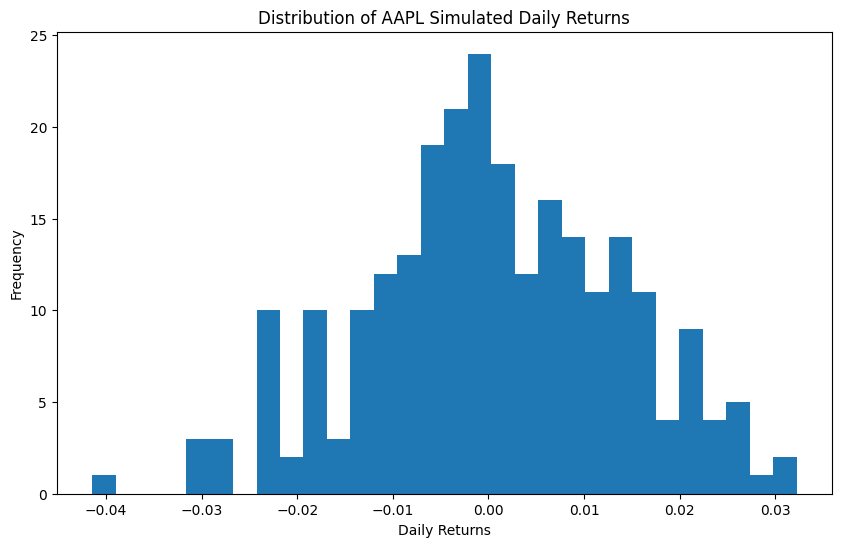

In [94]:
# Distribution of Daily Returns
plt.figure(figsize=(10, 6))
plt.hist(returns_sim, bins=30)
plt.title(f'Distribution of {stock} Simulated Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

By using these series of future daily return percentages, I can create future price series by adding these daily return percentages to the last price in the session (last simulated price or sim_prices[-1]). This calculation will create a series of price predictions for the next 252 trading days.

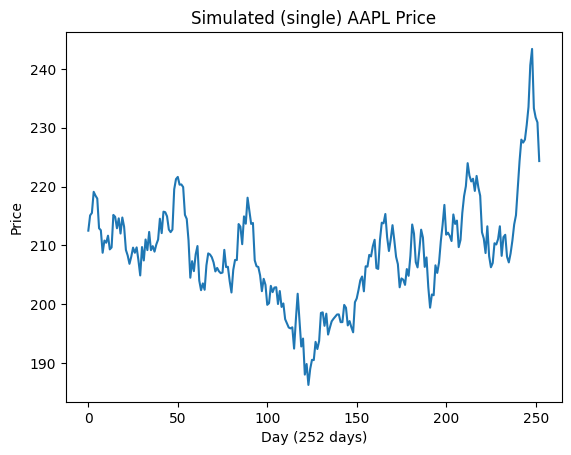

In [95]:
#Creating the simulated prices
sim_prices = [data["Adj Close"].iloc[-1]]
for j in returns_sim:
    sim_prices.append(sim_prices[-1] * (j+1))

#Let's plot this single 'random walk' of stock prices
plt.plot(sim_prices)
plt.title(f'Simulated (single) {stock} Price')
plt.xlabel("Day (252 days)")
plt.ylabel("Price")
plt.show()

Now that I've created a single **random walk** above, I will iterate this process over a few thousand times to get a large sample size by generating many random values of the daily return percentages. Using these daily return percentages, I will predict future prices & portfolio values. Once the simulation is complete, there is a collection of future prices from which I can deduce a probabilistic interpretation.

In [96]:
# imulate future returns using Monte Carlo
mean = np.mean(returns) # require to annualized?
std_dev = np.std(returns) # require to annualized?
df_sim_prices = pd.DataFrame()
df_sim_port_vals = pd.DataFrame()
for i in range(num_simulations):
    simulated_returns = np.random.normal(mean, std_dev, simulation_horizon) #, num_simulations))

    sim_prices = [data["Adj Close"].iloc[-1]]
    day_sim_port_vals = [initial_investment] # start from the initial investment
    for j in simulated_returns: #simulation horizon
        sim_prices.append(sim_prices[-1] * (1 + j))
        day_sim_port_vals.append(day_sim_port_vals[-1] * (1 + j))
    
    df_sim_prices[i] = sim_prices
    df_sim_port_vals[i] = day_sim_port_vals

#Calculate the average portfolio values for VaR calculation later
sim_port_avg = df_sim_port_vals.mean(axis=0)


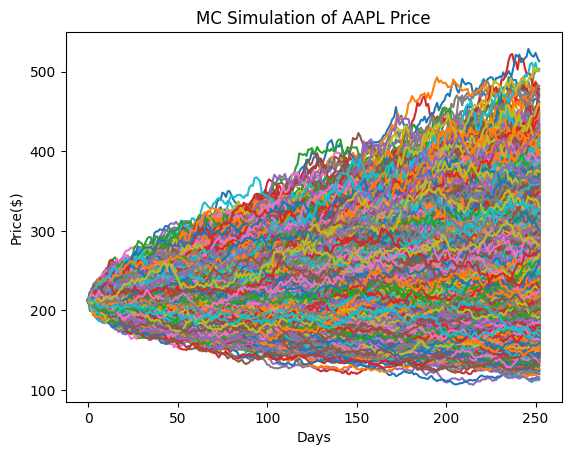

In [97]:
plt.plot(df_sim_prices)
plt.ylabel('Price($)')
plt.xlabel('Days')
plt.title(f'Monte Carlo Simulation of {stock} Price')
plt.show()

The upside potential (reward) is about 300 (500 - 200), and the downside potential (risk) is about 80 (200 - 120).

**Calculation VaR & CVaR**

In [98]:
#Function to calculate the MCS VaR at each confidence levels
def VaR_MCS(values, confidence_level):
    return np.percentile(values, (1 - confidence_level) * 100)

def CVaR_MCS(values,confidence_level):
    belowVaR = values <= VaR_MCS(values, confidence_level)
    return values[belowVaR].mean()

#Get the VaR at each confidence level & print it
VaR_MCSs = [abs(initial_investment-VaR_MCS(sim_port_avg, conf_level)) for conf_level in confidence_levels]
for idx, conf_level in enumerate(confidence_levels):
    print(f"MCS VaR ({round(conf_level*100)}% confidence level): {round(VaR_MCSs[idx])}")

print("\n")
CVaR_MCSs = [abs(initial_investment-CVaR_MCS(sim_port_avg, conf_level)) for conf_level in confidence_levels]
for idx, conf_level in enumerate(confidence_levels):
    print(f"MCS CVaR ({round(conf_level*100)}% confidence level): {round(CVaR_MCSs[idx])}")

MCS VaR (90% confidence level): 8461
MCS VaR (95% confidence level): 12409
MCS VaR (99% confidence level): 19326


MCS CVaR (90% confidence level): 13291
MCS CVaR (95% confidence level): 16374
MCS CVaR (99% confidence level): 21976


After reading about VaR & CVaR in Investopedia, I got the following understandings of the above results:<br>
There is 90% confidence that the worst daily loss will not exceed $8,461 or the asset has a 10% probability of losing its value by $8,461 in the upcoming days.<br>
There is 95% confidence that the worst daily loss will not exceed $12,409 or the asset has a  5% probability of losing its value by $12,409 in the upcoming days.<br>
There is 99% confidence that the worst daily loss will not exceed $19,326 or the asset has a  1% probability of losing its value by $19,326 in the upcoming days.<br><br>
On the other hand, CVaR (aka Expected Shortfall) estimates the expected loss if the assets go beyond the VaR cut-off.<br>
A 90% CVaR of $13,291 means that the expected loss of the worst 10% scenarios is $13,291. <br>
A 95% CVaR of $16,374 means that the expected loss of the worst  5% scenarios is $16,374. <br>
A 99% CVaR of $21,976 means that the expected loss of the worst  1% scenarios is $21,976. <br>

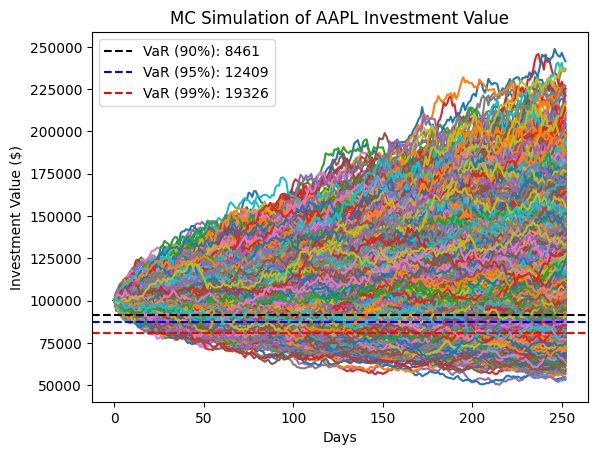

In [99]:
plt.plot(df_sim_port_vals)
colors = ['k', 'b', 'r']
for idx, conf_level in enumerate(confidence_levels):
    plt.axhline(round(abs(initial_investment-VaR_MCSs[idx])), color=colors[idx], linestyle='--', label=f'VaR ({round(conf_level*100)}%): {round(VaR_MCSs[idx])}')
plt.ylabel('Investment Value ($)')
plt.xlabel('Days')
plt.title(f'Monte Carlo Simulation of {stock} Investment Value')
plt.legend()
plt.show()

Based on this result, it is clear that the upside potential is higher than the downside potential, or the volatility is getting wider as it moves forward in the trading days. This simulation assumes that the volatility continues.

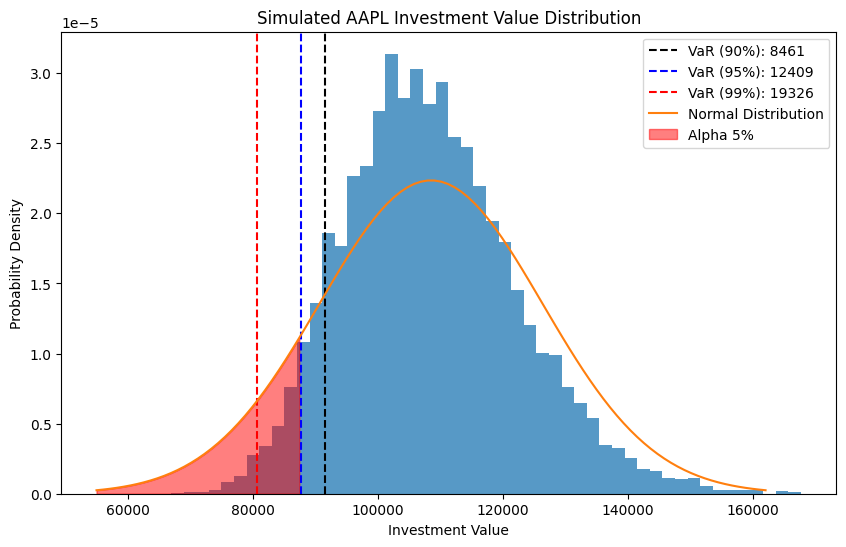

In [100]:
#Plot the distribution of simulated portfolio returns and VaR threshold
plt.figure(figsize=(10, 6))
plt.hist(sim_port_avg, density=True, bins=50, alpha=0.75)

#VaR line
colors = ['k', 'b', 'r']
for idx, conf_level in enumerate(confidence_levels):
    plt.axvline(round(abs(initial_investment-VaR_MCSs[idx])), color=colors[idx], linestyle='--', label=f'VaR ({round(conf_level*100)}%): {round(VaR_MCSs[idx])}')

#plot distribution line
mu, std = norm.fit(df_sim_port_vals)
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, label='Normal Distribution')
#fill in CVaR 99%
plt.fill_between(x, 0, y, where=(x <= round(abs(initial_investment-VaR_MCSs[1]))), color=colors[2], alpha=0.5, label='Alpha 5%')

plt.title(f'Simulated {stock} Investment Value Distribution')
plt.xlabel('Investment Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [101]:
desired_return = 0.12  #Desired return (12%)
num_success = np.sum(sim_port_avg >= initial_investment * (1 + desired_return))
probability_of_success = num_success / num_simulations

print(f"Probability of achieving at least a {desired_return*100}% return: {probability_of_success*100:.2f}%")

Probability of achieving at least a 12.0% return: 36.98%


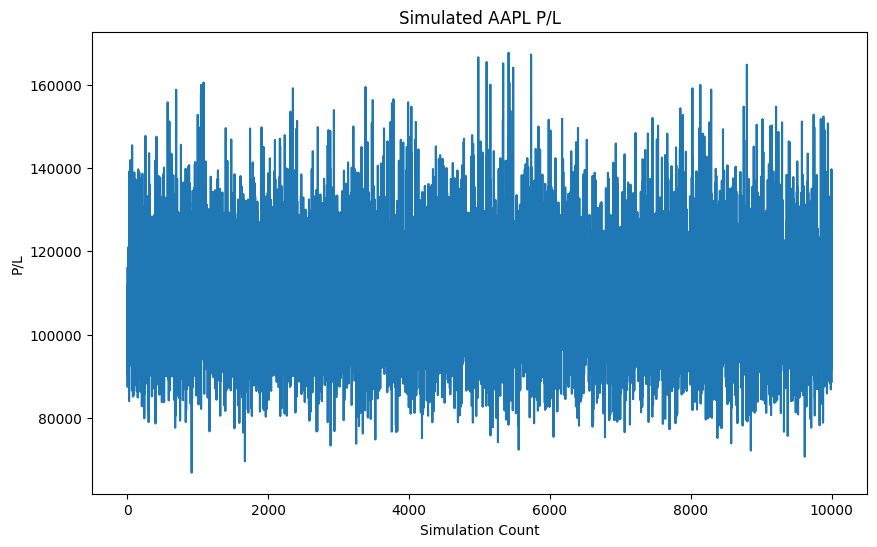

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(sim_port_avg)
plt.title(f'Simulated {stock} P/L')
plt.xlabel('Simulation Count')
plt.ylabel('P/L')
plt.show()

**Compare MCS VaR with Historical & Parametric VaR**

In [103]:
#Use Historical VaR & Parametric VaR to compare VaR generated by MCS
#Calculate portfolio value daily moving forward for 252 days
port_vals = [initial_investment] # start from the initial investment
for j in returns:
    port_vals.append(port_vals[-1] * (1 + j))

#put into DataFrame for easy display/access
df_port_vals = pd.DataFrame({'Portfolio':port_vals})
#take portfolio value only for easier plotting
port_vals_arr=df_port_vals['Portfolio']

#Calculate the historical VaR at 95% confidence level
def VaR_Historical(values, confidence_level):
    return np.percentile(values, (1 - confidence_level) * 100)

VaR_Historicals = [abs(initial_investment-VaR_Historical(port_vals_arr, conf_level)) for conf_level in confidence_levels]

#Calculate Parametric VaR (Variance-Covariance VaR)
#Calculate the mean and standard deviation of simulated portfolio
mean_return = np.mean(port_vals_arr)
std_dev = np.std(port_vals_arr)

def VaR_Parametric(values, confidence_level):
    mu = np.mean(values)
    std = np.std(values)
    z_score = norm.ppf(1 - confidence_level)
    return mu + z_score * std

VaR_Parametrics = [abs(initial_investment-VaR_Parametric(port_vals_arr, conf_level)) for conf_level in confidence_levels]

In [104]:
print('CVaR Comparison for different methods')
print('--'*19)
df_VaR_CVaR_Compare = pd.DataFrame({
    'Confidence Level': ['90%', '95%', '99%'],
    'Historical VaR': VaR_Historicals,
    'Parametric VaR': VaR_Parametrics,
    'MCS VaR': VaR_MCSs,
    'MCS CVaR': CVaR_MCSs
})
display(df_VaR_CVaR_Compare.round(2))

CVaR Comparison for different methods
--------------------------------------


,Confidence Level,Historical VaR,Parametric VaR,MCS VaR,MCS CVaR
0,90%,8174.46,7703.08,8461.05,13291.32
1,95%,8745.40,9533.99,12409.15,16373.72
2,99%,10036.19,12968.46,19325.51,21976.32


The Monte Carlo Simulation generated VaRs are slightly higher when the confidence level is higher. However, I have no experience to justify if these variabilities are acceptable.

**Conclusion:**<br>
I think Monte Carlo Simulation is a great tool to analyze a probabilistic view of future stock prices/other events.<br>
* The upside potential is about 300 (500 - 200), and the downside potential is about 80 (200 - 120).
* There is about 37% that AAPL will return more than 12% in a year. 
* The downside potential (VaR and CVaR) is about 8-20% of the initial investment value depending on the confidence levels.

Since this project is my first time calculating VaR & CVaR, I have yet to learn to make decisions based on these results.
However, I think I will not buy a stock solely based on Monte Carlo Simulation.

*References*: <br>
https://math.gmu.edu/~tsauer/ (Numerical Analisys textbook)<br>
https://pbpython.com/monte-carlo.html <br>
https://medium.com/@whystudying/monte-carlo-simulation-with-python-13e09731d500 <br>
https://www.interviewqs.com/blog/intro-monte-carlo <br>
https://www.investopedia.com/terms/m/montecarlosimulation.asp <br>
https://stats.libretexts.org/Bookshelves/Computing_and_Modeling/RTG%3A_Simulating_High_Dimensional_Data/The_Monte_Carlo_Simulation_Method <br>
https://blog.quantinsti.com/value-at-risk/
https://github.com/quantrocket-codeload/quant-finance-lectures/tree/master/quant_finance_lectures